# Note: Code and ideas came from Book - [Bandit Algorithms for Website Optimization](https://www.amazon.com/Bandit-Algorithms-Website-Optimization-Developing-ebook/dp/B00AM86Y0K/ref=sr_1_5?dchild=1&keywords=Bandit+Algorithms+for+Website+Optimization&qid=1616986673&sr=8-5) and also from https://imaddabbura.github.io/ which is based on the book to begin with. 

## I have made changes to make this work in Google Colab environment - by flattening all the code into one big ipynb file. 

For this tutorial, I have only taken Epsilon Greedy. For those who want to play with other 2 algos, get the book [here](https://www.amazon.com/Bandit-Algorithms-Website-Optimization-Developing-ebook/dp/B00AM86Y0K/ref=sr_1_5?dchild=1&keywords=Bandit+Algorithms+for+Website+Optimization&qid=1616986673&sr=8-5) or check out Imaddabbura.github.io site. 

### For those of you want a refresher for Google Colab, here's a source for you to get started - https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c

In [ ]:
from google.colab import drive
# mount google drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


### Note - this is my folder structure in my google drive. Based on where you will store this file and the data file, you need to change this path

In [ ]:
cd drive/MyDrive/

In [ ]:
cd AB\ Testing

/content/drive/MyDrive/AB Testing


In [ ]:
# Import packages
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [ ]:
# Add module path to system path
#sys.path.append(os.path.abspath("./")). In my case, I have put all the module code into this one file. 
#from utils import plot_algorithm, compare_algorithms

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

## EpsilonGreedy 

### 
> epsilon

This will be a floating point number that tells us the frequency with which we should explore one of the available arms. If we set epsilon = 0.1, then we’ll explore the available arms on 10% of our pulls.

> counts

A vector of integers of length N that tells us how many times we’ve played each of the N arms available to us in the current bandit problem. If there are two arms, Arm 1 and Arm 2, which have both been played twice, then we’ll set counts = [2, 2].

> values

A vector of floating point numbers that defines the average amount of reward we’ve gotten when playing each of the N arms available to us. If Arm 1 gave us 1 unit of reward on one play and 0 on another play, while Arm 2 gave us 0 units of reward on both plays, then we’ll set values = [0.5, 0.0].


In [ ]:
# Epsilon Greedy
"""
Implementing epsilon-Greedy algorithm in both standard and annealing forms.
"""

import numpy as np


class EpsilonGreedy:
    """Implementing standard epsilon-Greedy algorithm.

    Parameters
    ----------
    epsilon : float
        probability of exploration and trying random arms.
    counts : list or array-like
        number of times each arm was played, shape (num_arms,).
    values : list or array-like
        estimated value (mean) of rewards of each arm, shape (num_arms,).

    Attributes
    ----------
    select_arm : int
        select the best arm with probability (1 - epsilon) or randomly select
        any arm available with probability (1 / N) for each arm.
    """

    def __init__(self, epsilon, counts=None, values=None):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

# Because the epsilon-Greedy algorithm’s behavior is very strongly controlled by 
# the settings of both counts and values, we also provide 
# explicit initialization methods that let you reset these 
# variables to their proper blank slate states before letting the algorithms loose

    def initialize(self, n_arms):
        """Initialize counts and values array with zeros."""
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

# select_arm

# Every time we have to make a choice about which arm to pull, we want to be able 
# to simply make a call to our favorite algorithm and have it tell us the numeric 
# name of the arm we should pull. Throughout this book, all of the bandit algorithms 
# will implement a select_arm method that is called without any arguments and which 
# returns the index of the next arm to pull.


    def select_arm(self):
        z = np.random.random()
        if z > self.epsilon:
            # Pick the best arm. argmax returns the index of the maximum value

            return np.argmax(self.values)
        # Randomly pick any arm with prob 1 / len(self.counts)
        return np.random.randint(0, len(self.values))

# update
# After we pull an arm, we get a reward signal back from our system. 
# We want to update our algorithm’s beliefs about the quality of the arm we just 
# chose by providing this reward information. 
# This an update function that takes as arguments 
# (1) an algorithm object, 
# (2) the numeric index of the most recently chosen arm and 
# (3) the reward received from choosing that arm. 

# The update method will take this information and make the relevant changes to 
# the algorithm’s evaluation of all of the arms.


    def update(self, chosen_arm, reward):
        """Update counts and estimated value of rewards for the chosen arm."""
        # Increment chosen arm's count by one
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Recompute the estimated value of chosen arm using new reward
        value = self.values[chosen_arm]
        new_value = value * ((n - 1) / n) + reward / n
        self.values[chosen_arm] = new_value



### BernoulliArm
#### Dealing with an arm that rewards you with a value of 1 some percentage of the time and rewards you with a value of 0 the rest of the time.

##### This is akin to simulate situations like click-throughs or user signups: 


> 1. the potential user arrives at your site; 
> 2. you select an arm for them in which you, show them one specific color logo; 
> 3. They either do sign up for the site (and give you reward 1) or they don’t (and give you reward 0).


If 2% of people who see a red logo or button sign up and 5% of people who see a green logo or button sign up, then one arm outputs 1 unit of reward 2% of the time, the other arm outputs 1 unit of reward 5% of the time. This situation is what we call a Bernoulli arm. 

In [ ]:
"""
Use Monte Carlo simulations to test bandit algorithms.
"""

import numpy as np


class BernoulliArm:
    """Draw an arm's reward from a Bernoulli distribution.
    Parameters
    ----------
    p : float
            probability of getting reward for a specific arm.

    Attributes
    ----------
    draw : float
        rewards drawn using Bernoulli probability distribution.
    """
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0



## Testing Algorithm

### This is a very generic framework for testing an algorithm.
#### We call this test utility in Plot Algorithm. 

#### How does this framework work?

We pass in a few objects:

>1. A bandit algorithm that we want to test.

>2. An array of arms we want to simulate draws from.

>3. A fixed number of simultations to run to average over the noise in each simulation.

>4. The number of times each algorithm is allowed to pull on arms during each simulation. Any algorithm that’s not terrible will eventually learn which arm is best; the interesting thing to study in a simulation is whether an algorithm does well when it only has 100 (or 100,000) tries to find the best arm.

>5. The framework then uses these objects to run many independent simulations. For each of these, it:

>6. Initializes the bandit algorithm’s settings from scratch so that it has no prior knowledge about which arm is best.
Loops over opportunities to pull an arm. On each step of this loop, it:

>7. Calls select_arm to see which arm the algorithm chooses.
>8. Calls draw on that arm to simulate the result of pulling that arm.

>9. Records the amount of reward received by the algorithm and then calls update to let the algorithm process that new piece of information.

>10. Finally, the testing framework returns a data set that tells us for each simulation which arm was chosen and how well the algorithm did at each point in time. In the code directory associated with this book, there are R scripts that plot out the performance to give you a feel for how these algorithms perform. We won’t step through that code in detail in this book, but it is available online in the same GitHub repository as you’re using for all of the other code for this book. Instead of walking through our graphics code, we’ll show you plots that describe what happens during our simulations and try to make sure you understand the main qualitative properties you should be looking for in the data you’ll get from your own simulations.


In [ ]:
def test_algorithm(algo, arms, num_simulations, horizon):
    # Initialize rewards and chosen_arms with zero 2d arrays
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))

    # Loop over all simulations
    for sim in range(num_simulations):
        # Re-initialize algorithm's counts and values arrays
        algo.initialize(len(arms))

        # Loop over all time horizon
        for t in range(horizon):
            # Select arm
            chosen_arm = algo.select_arm()
            chosen_arms[sim, t] = chosen_arm

            # Draw from Bernoulli distribution to get rewards
            reward = arms[chosen_arm].draw()
            rewards[sim, t] = reward

            # Update the algorithms' count and estimated values
            algo.update(chosen_arm, reward)

    # Average rewards across all sims and compute cumulative rewards
    average_rewards = np.mean(rewards, axis=0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

In [ ]:
"""
Plots Bandit Algorithms performance.
"""

import matplotlib.pyplot as plt
import numpy as np

#from epsilon_greedy_algorithm import (
#    EpsilonGreedy,
#    AnnealingEpsilonGreedy
#    )
#from bandit_algorithms.softmax.softmax_algorithm import (Softmax,
#                                                         AnnealingSoftmax)
#from bandit_algorithms.upper_confidence_bound.ucb import UCB
#from testing.test_bandit_algorithms import BernoulliArm, test_algorithm


ALGORITHMS = {
    "epsilon-Greedy": EpsilonGreedy,
    "Annealing epsilon-Greedy": AnnealingEpsilonGreedy
}


In [ ]:
def plot_algorithm(
        alg_name="epsilon-Greedy", arms=None, best_arm_index=None,
        hyper_params=None, num_simulations=1000, horizon=100, label=None,
        fig_size=(18, 6)):
    # Check if the algorithm doesn't have hyperparameter
    if hyper_params is None:
        # Run the algorithm
        algo = ALGORITHMS[alg_name]()
        chosen_arms, average_rewards, cum_rewards = test_algorithm(
            algo, arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(
            axis=0) / num_simulations

        # Plot the 3 metrics of the algorithm
        fig, axes = plt.subplots(1, 3, figsize=fig_size)
        axes[0].plot(average_probs)
        axes[0].set_xlabel("Time", fontsize=14)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
        axes[0].set_title(
            f"Accuray of {alg_name} alg.", y=1.05, fontsize=16)
        axes[0].set_ylim([0, 1.05])
        axes[1].plot(average_rewards)
        axes[1].set_xlabel("Time", fontsize=14)
        axes[1].set_ylabel("Average Reward", fontsize=14)
        axes[1].set_title(
            f"Avg. Rewards of {alg_name} alg.", y=1.05, fontsize=16)
        axes[1].set_ylim([0, 1.0])
        axes[2].plot(cum_rewards)
        axes[2].set_xlabel("Time", fontsize=14)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
        axes[2].set_title(
            f"Cumulative Rewards of {alg_name} alg.", y=1.05, fontsize=16)
        plt.tight_layout()

    else:
        fig, axes = plt.subplots(1, 3, figsize=fig_size)
        for hyper_param in hyper_params:
            # Run the algorithm
            algo = ALGORITHMS[alg_name](hyper_param)
            chosen_arms, average_rewards, cum_rewards = test_algorithm(
                algo, arms, num_simulations, horizon)
            average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(
                axis=0) / num_simulations

            # Plot the 3 metrics of the algorithm
            axes[0].plot(average_probs, label=f"{label} = {hyper_param}")
            axes[0].set_xlabel("Time", fontsize=14)
            axes[0].set_ylabel(
                "Probability of Selecting Best Arm", fontsize=14)
            axes[0].set_title(
                f"Accuray of {alg_name} alg.", y=1.05, fontsize=16)
            axes[0].legend()
            axes[0].set_ylim([0, 1.05])
            axes[1].plot(average_rewards, label=f"{label} = {hyper_param}")
            axes[1].set_xlabel("Time", fontsize=14)
            axes[1].set_ylabel("Average Reward", fontsize=14)
            axes[1].set_title(
                f"Avg. Rewards of {alg_name} alg.", y=1.05, fontsize=16)
            axes[1].legend()
            axes[1].set_ylim([0, 1.0])
            axes[2].plot(cum_rewards, label=f"{label} = {hyper_param}")
            axes[2].set_xlabel("Time", fontsize=14)
            axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
            axes[2].set_title(
                f"Cumulative Rewards of {alg_name} alg.", y=1.05, fontsize=16)
            axes[2].legend(loc="lower right")
            plt.tight_layout()


def compare_algorithms(
        algorithms=None, arms=None, best_arm_index=None, num_simulations=1000,
        horizon=100, fig_size=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    # Loop over all algorithms
    for algorithm in algorithms:
        # Run the algorithm
        algo = ALGORITHMS[algorithm]
        chosen_arms, average_rewards, cum_rewards = test_algorithm(
            algo(), arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(
            axis=0) / num_simulations

        # Plot the 3 metrics
        axes[0].plot(average_probs, label=algo.__name__)
        axes[0].set_xlabel("Time", fontsize=12)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=12)
        axes[0].set_title(
            f"Accuray of Different Algorithms", y=1.05, fontsize=14)
        axes[0].set_ylim([0, 1.05])
        axes[0].legend(loc="lower right")
        axes[1].plot(average_rewards, label=algo.__name__)
        axes[1].set_xlabel("Time", fontsize=12)
        axes[1].set_ylabel("Average Reward", fontsize=12)
        axes[1].set_title(
            f"Average Rewards of Different Algorithms", y=1.05, fontsize=14)
        axes[1].set_ylim([0, 1.0])
        axes[1].legend(loc="lower right")
        axes[2].plot(cum_rewards, label=algo.__name__)
        axes[2].set_xlabel("Time", fontsize=12)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=12)
        axes[2].set_title(
            f"Cumulative Rewards of Different Algorithms", y=1.05, fontsize=14)
        axes[2].legend(loc="lower right")
        plt.tight_layout()

In [ ]:
np.random.seed(1)
# Average reward by arm
# This is an array of Arm options. As a product manager, based on your domain expertises and goals of this AB testing, you can customize these
# This will set up an array that contains 5 arms. 4 of them output reward 10% of the time, while the best of them outputs a reward 90% of the time.

means = [0.1, 0.1, 0.1, 0.1, 0.9]

n_arms = len(means)
# Shuffle the arms
np.random.shuffle(means)
# Each arm will follow and Bernoulli distribution
arms = list(map(lambda mu: BernoulliArm(mu), means))




## Call out. Last year, author of book "Replication of John Myles White, Bandit Algorithms for Website Optimization" has updated some of these codes snippets. https://cran.r-project.org/web/packages/contextual/vignettes/website_optimization.html



In [ ]:
# Try your Arm code here
arms[0].draw()

0.0

In [ ]:
def ind_max(x):
  m = max(x)
  return x.index(m)


In [ ]:
print("Best arm is " + str(ind_max(means)))

Best arm is 2


In [ ]:
# Get the index of the best arm to test if algorithm will be able to learn that
best_arm_index = np.argmax(means)
# Define epsilon value to check the performance of the algorithm using each one
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]


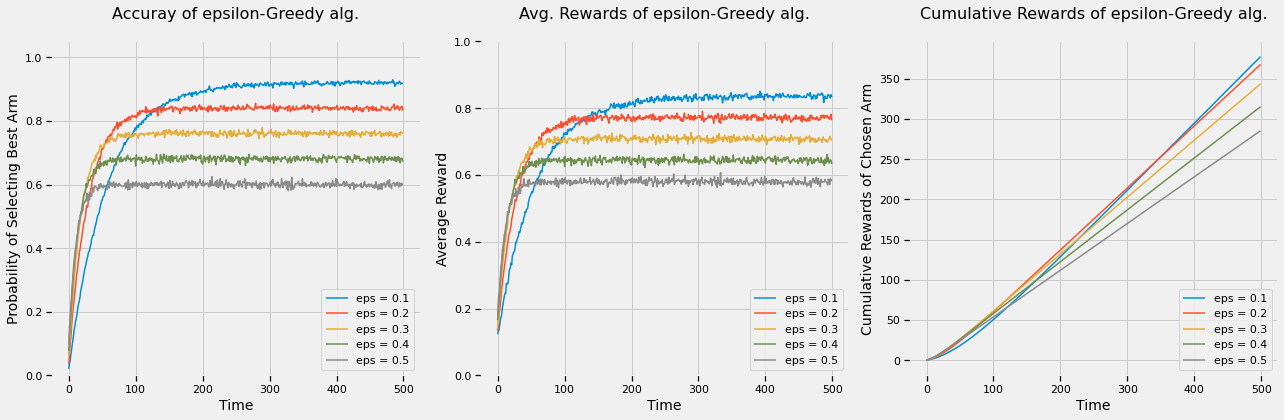

In [ ]:
# Plot the epsilon-Greedy algorithm
plot_algorithm(alg_name="epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=5000, horizon=500, label="eps")

## Call outs
### Track the Probability of Choosing the Best Arm

#### The first analytic approach, and certainly the simplest, is to keep track of the odds that our algorithm selects the best arm at any given point in time. We need to work with odds for two different reasons: (1) the algorithm uses randomization when choosing which arm to pull and may therefore not select the best arm even after it’s learned which arm is best and (2) the rewards that the algorithm receives are random as well. For those reasons, there is always a chance that the algorithm will not make the best decision on any specific trial.

#### As such, we’ll explicitly calculate the probability of selecting the best arm by estimating the percentage of times in our simulations when the algorithm chose the best arm. If the probability that the algorithm picks the best arm doesn’t go up over time, then we don’t really have any evidence that our algorithm is learning anything about the values of the arms.

### 1st Plot - Track the Probability of Choosing the Best Arm

> The x-axis shows the number of times the algorithm has been able to pull on any of the five arms that are available. 

> The y-axis shows the probability that the algorithm, when we called select_arm(), chose the best of the five arms at each point in time.

> The actual values of the curves are the averages across the 5,000 simulations we ran to estimate the algorithm’s performance. We needed to run 5,000 simulations to get around the amount of noise in each simulation caused by using a random number generator in our simulations.

><b> If epsilon is high, we <u>explore</u> a lot and find the best arm quickly, but then we keep exploring even after it’s not worth doing anymore. When epsilon is high, our system’s peak performance is fairly low. (Gray line)</b>

> In contrast to the high values of epsilon, the lowest value of epsilon, which was 0.1, causes the algorithm to explore much more slowly, but eventually the algorithm reaches a much higher peak performance level. In many ways, the different settings of epsilon embody the Explore-Exploit trade-off as a whole: the settings that lead to lots of exploration learn quickly, but don’t exploit often enough at the end; whereas the settings that lead to little exploration learn slowly, but do well at the end.

> Just like traditional AB Testing, which approach is best depends on which point in time you’re looking at. This is why we need to always be concerned about the length of time we intend to leave a bandit algorithm running. The number of pulls that the bandit algorithm has left to it is typically called the horizon. Which algorithm is best depends strongly on the length of the horizon.

### 2nd Plot - Track the Average Reward at Each Point in Time

Instead of looking at the probability of picking the best arm, another simple approach to measuring our algorithm’s performance is to use the average reward that our algorithm receives on each trial. When there are many arms similar to the best, each of which is just a little worse than the best, this average reward approach is a much better method of analysis than our approach using probabilities of selecting the best arm. 

In this specific case, the results are quite similar because (A) the rewards are so far apart and because (B) the rewards are all 0’s or 1’s.


### 3rd Plot -  Track the Cumulative Reward at Each Point in Time

Ultimately, there’s something lacking in both of the approaches we’ve taken: they’re too narrowly focused on the performance of the algorithm at each fixed point in time and don’t give us a gestalt picture of the lifetime performance of our algorithm. This myopic focus on each point in time in isolation is unfair to versions of the epsilon-Greedy algorithm in which epsilon is large, because these algorithms, by definition, explore worse options more frequently than algorithms for which epsilon is low. This is a sacrifice they intentionally make in order to explore faster. To decide whether that increased exploration is worth the trouble, we shouldn’t focus on the performance of the algorithm at any specific point in time, but rather on its cumulative performance over time.

We can analyze the cumulative reward of our algorithms, which is simply the total amount of reward that an algorithm has won for us up until some fixed point in time. This cumulative reward is important, because it treats algorithms that do a lot of exploration at the start as a means of finding the best available arm more fairly.

In fact, looking at the cumulative results, you can see that curves for the low value of epsilon = 0.1 and the high value of epsilon = 0.5 intersect after about 130 rounds: before then, it was good to have explored a lot, but after then it was better to have been able to exploit more consistently once the algorithm had found the best arm.

In [ ]:
# Above code takes about 2.30 secons to run with 5000 simulations. 
